<a href="https://colab.research.google.com/github/Somcodo4/rul-prediction-of-lithium-ion-batteries/blob/main/IK_LongShortTermMemory_with_cycle_count.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#LongShortTermMemory Model
#Get libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load your dataset
data = pd.read_csv('Battery_RUL_II cleaned 2.csv')  # Replace 'your_dataset.csv' with your actual file path

In [4]:
data.head() # This will call the head() method of the data object, which is a DataFrame.

,Cycle Count,Discharge Time,Decrement time 3.6 V to 3.4 V,Max Voltage Discharge,Min Voltage Charge,Time at 4.15 V,Time constant current,Charging time,RUL
0,1,2595.30,1151.488500,3.670,3.211,5460.001000,6755.01,10777.82,1112
1,2,7408.64,1172.512500,4.246,3.220,5508.992000,6762.02,10500.35,1111
2,3,7393.76,1112.992000,4.249,3.224,5508.993000,6762.02,10420.38,1110
3,4,7385.50,1080.320667,4.250,3.225,5502.016000,6762.02,10322.81,1109
4,7,3301.18,1194.235077,3.674,3.504,5023.633636,5977.38,5977.38,1106


In [5]:
data.tail() # This will call the tail() method of the data object, which is a DataFrame.

,Cycle Count,Discharge Time,Decrement time 3.6 V to 3.4 V,Max Voltage Discharge,Min Voltage Charge,Time at 4.15 V,Time constant current,Charging time,RUL
14840,1107,773.00,180.480000,3.774,3.742,922.712,1412.31,6659.62,5
14841,1108,770.44,179.523809,3.773,3.742,922.775,1412.38,6678.88,4
14842,1109,771.12,179.523809,3.773,3.744,915.512,1412.31,6670.38,3
14843,1110,769.12,179.357143,3.773,3.742,915.513,1412.31,6637.12,2
14844,1111,773.88,162.374667,3.763,3.839,539.375,1148.00,7660.62,1


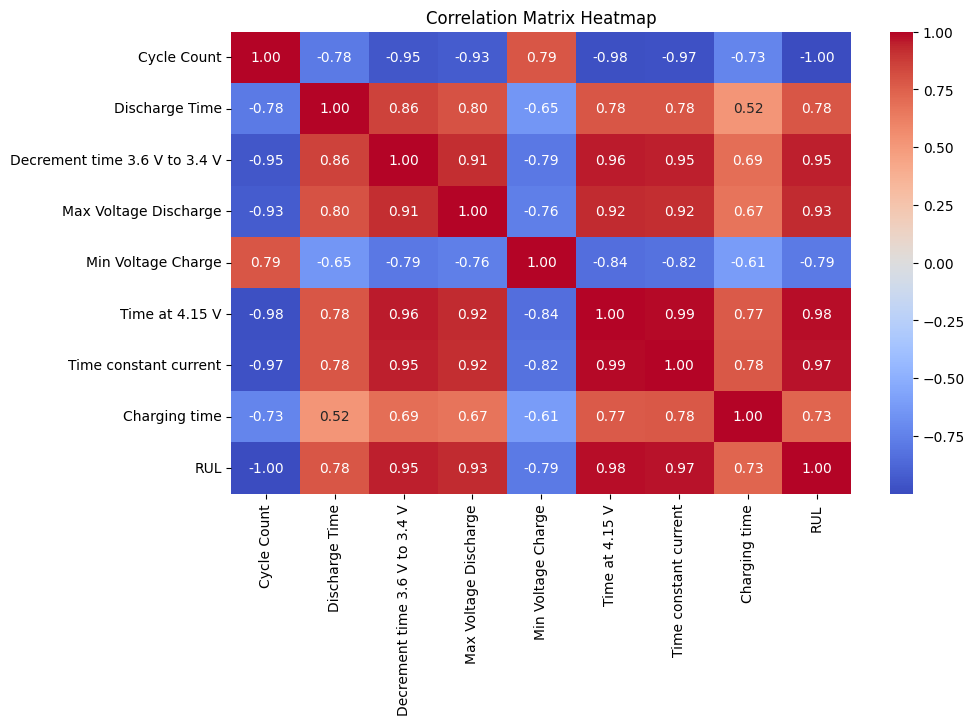

In [6]:
# Calculate Correlation Matrix
correlation_matrix = data.corr()

# Visualize the Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [7]:
# Select features and target variable
features = ['Cycle_Index', 'Discharge Time (s)', 'Decrement 3.6-3.4V (s)',
            'Max Voltage Dischar. (V)', 'Min Voltage Charg. (V)',
            'Time at 4.15V (s)', 'Time constant current (s)', 'Charging time (s)']
target = 'RUL'


In [8]:
# Split features (X) and target variable (y)
X = data.drop(columns=['RUL'])  # Change 'df' to 'data'
y = data['RUL']  # Change 'df' to 'data'

In [9]:
#Scale the features
# Scale the features and target using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit the scalers to the data
X_scaled = scaler_X.fit_transform(X)
# Reshape the target variable using .values.reshape() to be compatible with MinMaxScaler
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [10]:
# Function to create sequences of data for LSTM
def create_sequences(X, y, time_steps=50):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

# Create sequences
time_steps = 50
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps=time_steps)

# Split the data into training and testing sets
train_size = int(0.85 * len(X_seq))  # 85% for training
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]


In [11]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Add dropout to prevent overfitting
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mse')


In [12]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.15, verbose=1) #test it at 32 batch size then increase to 64

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



Epoch 1/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 0.0207 - val_loss: 0.0023
Epoch 2/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - loss: 0.0051 - val_loss: 0.0020
Epoch 3/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - loss: 0.0044 - val_loss: 0.0018
Epoch 4/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 5/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 0.0035 - val_loss: 8.9388e-04
Epoch 6/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.0026 - val_loss: 8.7905e-04
Epoch 7/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 8/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 0.0019 - val_loss: 7.2273e-04
Epoch 9/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 0.0026 - val_loss: 8.7047e-04
Epoch 10/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 0.0023 - val_loss: 6.1577e-04
Epoch 11/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 0.0018 - val_loss: 5.8721e-04
Epoch 

70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Model Evaluation Metrics for RUL Prediction:
Mean Squared Error (MSE): 1428.08
Root Mean Squared Error (RMSE): 37.79
Mean Absolute Error (MAE): 20.51
R-squared (R²): 0.99


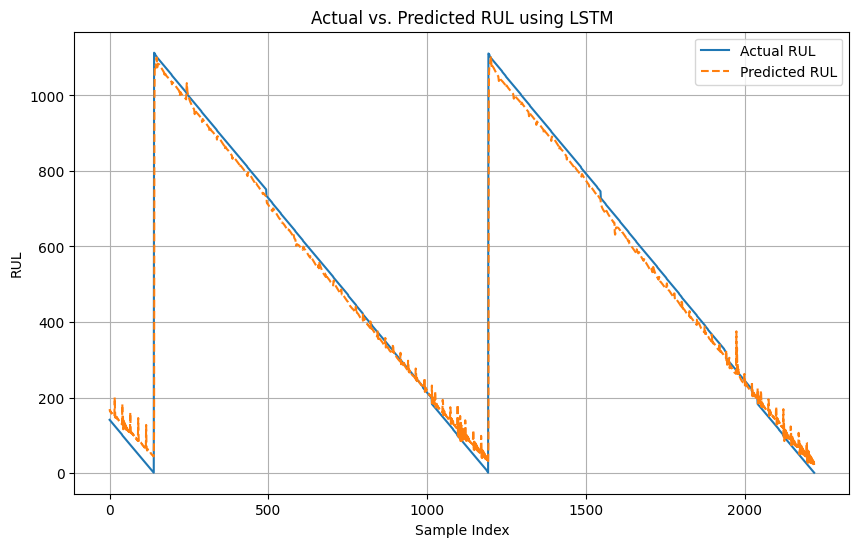

In [14]:
# Make predictions
y_pred_scaled = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

# Evaluate the model
mse = mean_squared_error(y_test_inv, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred)
r2 = r2_score(y_test_inv, y_pred)

print(f"Model Evaluation Metrics for RUL Prediction:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")

# Plot the actual vs. predicted RUL
plt.figure(figsize=(10,6))
plt.plot(y_test_inv, label='Actual RUL')
plt.plot(y_pred, label='Predicted RUL', linestyle='dashed')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.title('Actual vs. Predicted RUL using LSTM')
plt.legend()
plt.grid(True)
plt.show()


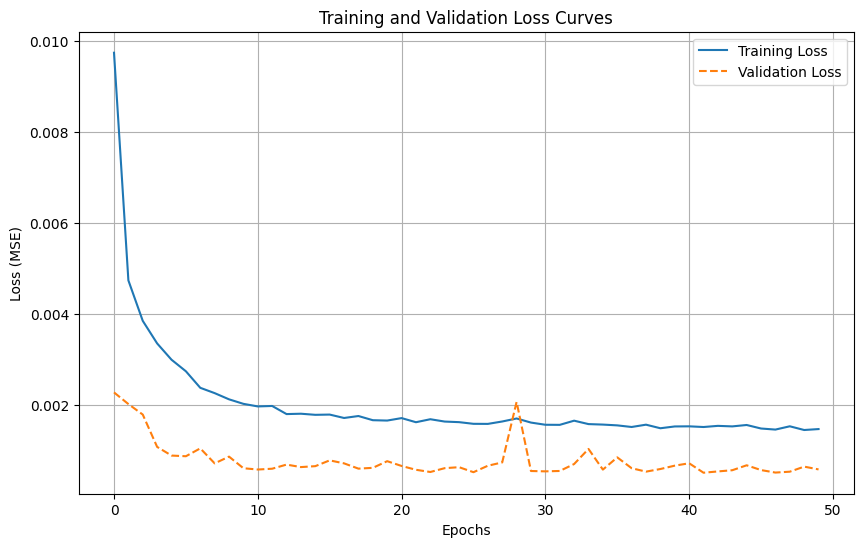

In [15]:
# Plot Training and Validation Loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


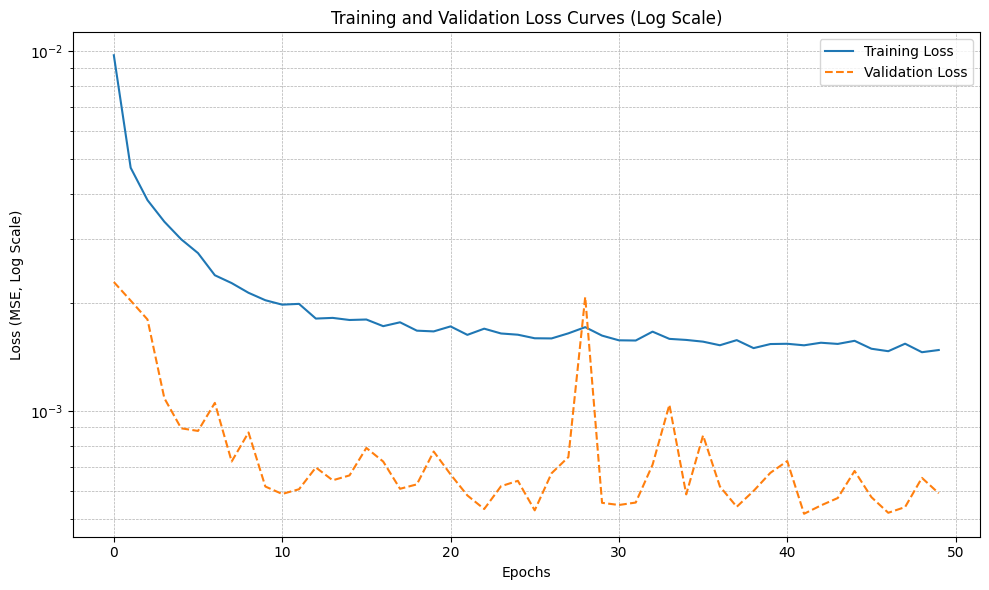

In [16]:
# Plot Training and Validation Loss with Logarithmic Y-axis
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='dashed')

plt.yscale('log')  # ← Log scale applied here

plt.title('Training and Validation Loss Curves (Log Scale)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE, Log Scale)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


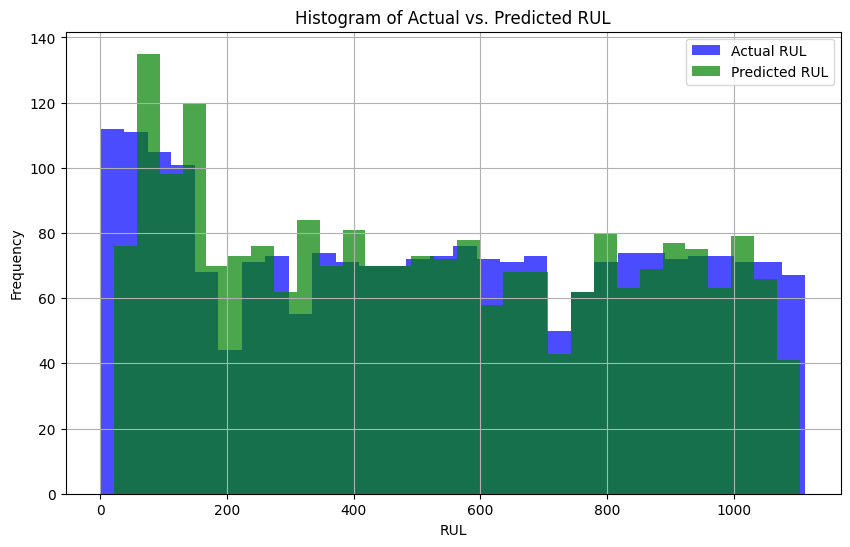

In [17]:
# Histogram of actual vs predicted RUL values
plt.figure(figsize=(10, 6))
plt.hist(y_test_inv, bins=30, alpha=0.7, label='Actual RUL', color='blue')
plt.hist(y_pred, bins=30, alpha=0.7, label='Predicted RUL', color='green')
plt.title('Histogram of Actual vs. Predicted RUL')
plt.xlabel('RUL')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()



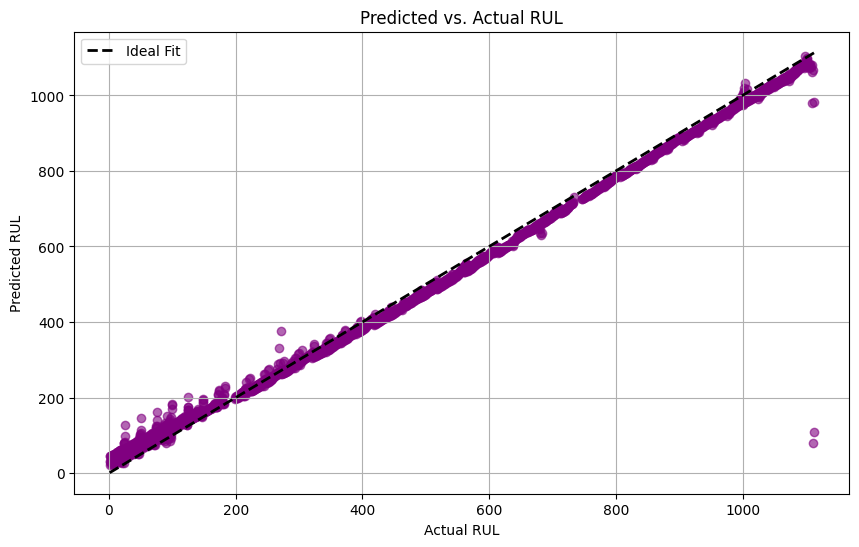

In [18]:
# Scatter plot of predicted vs actual RUL values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_inv, y_pred, alpha=0.6, color='purple')
plt.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], 'k--', lw=2, label='Ideal Fit')
plt.title('Predicted vs. Actual RUL')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
# Assume lstm_model, scaler_X, and scaler_y are already trained and loaded

# Function to get user input
def get_user_input():
    Cycle_Count = float(input("Enter Cycle Count: "))
    Discharge_Time = float(input("Enter Discharge Time (s): "))
    Decrement = float(input("Enter Decrement 3.6-3.4V (s): "))
    Max_Voltage_Discharge = float(input("Enter Max Voltage Discharge (V): "))
    Min_Voltage_Charge = float(input("Enter Min Voltage Charge (V): "))
    Time_at_415V = float(input("Enter Time at 4.15V (s): "))
    Time_constant_current = float(input("Enter Time constant current (s): "))
    Charging_time = float(input("Enter Charging time (s): "))
    return [Cycle_Count, Discharge_Time, Decrement, Max_Voltage_Discharge, Min_Voltage_Charge, Time_at_415V, Time_constant_current, Charging_time]

# Function to scale and reshape user input for the LSTM model
def preprocess_input_for_lstm(user_features, scaler_X, time_steps=50):
    # Convert user input to a NumPy array and scale it
    user_features_scaled = scaler_X.transform(np.array(user_features).reshape(1, -1))

    # Repeat the scaled features to create a sequence of the desired time steps
    user_features_seq = np.repeat(user_features_scaled, time_steps, axis=0)

    # Reshape to 3D array (samples, time_steps, features) for LSTM input
    user_features_seq = np.reshape(user_features_seq, (1, time_steps, user_features_scaled.shape[1]))

    return user_features_seq

# Function to predict RUL using the trained LSTM model
def predict_rul_lstm(user_features, lstm_model, scaler_X, scaler_y, time_steps=50):
    # Preprocess user input for the LSTM model
    user_features_seq = preprocess_input_for_lstm(user_features, scaler_X, time_steps)

    # Predict the scaled RUL using the LSTM model
    predicted_rul_scaled = lstm_model.predict(user_features_seq)

    # Inverse transform the predicted RUL to get the original scale
    predicted_rul = scaler_y.inverse_transform(predicted_rul_scaled).ravel()[0]

    return predicted_rul

# Function to map RUL to battery health categories
def map_to_battery_health(rul):
    if rul >= 741:
        return 'Excellent Battery Health'
    elif rul >= 371:
        return 'Average Battery Health'
    else:
        return 'Low or Poor Battery Health'

# Function to suggest optimization strategies based on battery health category
def suggest_optimization(category):
    if category == 'Excellent Battery Health':
        suggestions = [
            "Regular Monitoring: Continuously monitor the battery’s performance parameters.",
            "Optimal Charging Practices: Avoid overcharging and deep discharging. Use smart chargers.",
            "Temperature Management: Ensure the battery operates within the optimal temperature range.",
            "Balanced Usage: Ensure cells are balanced if the battery is part of a pack.",
            "Software Updates: Keep battery management software updated."
        ]
    elif category == 'Average Battery Health':
        suggestions = [
            "Conditioning Cycles: Perform controlled charging and discharging cycles.",
            "Reduced Load: Lower the load on the battery whenever possible.",
            "Partial Charging: Maintain the battery’s state of charge between 20% and 80%.",
            "Routine Maintenance: Regularly clean and check connections and terminals.",
            "Usage Adjustments: Adjust usage patterns to avoid high-drain scenarios."
        ]
    else:  # Low or Poor Battery Health
        suggestions = [
            "Capacity Testing: Regularly test the battery’s capacity.",
            "Load Reduction: Significantly reduce the load to prevent sudden failures.",
            "Refurbishment: Consider battery refurbishment options.",
            "Preemptive Replacement: Replace the battery to avoid unexpected failures.",
            "Recycling: Ensure proper recycling procedures for disposed batteries."
        ]
    return suggestions

# Example usage:
# Assuming 'lstm_model' is your trained LSTM model, and 'scaler_X' and 'scaler_y' are your fitted scalers

# Get user input for features
user_features = get_user_input()

# Predict RUL based on user input using the LSTM model
# Changed lstm_model to model
predicted_rul = predict_rul_lstm(user_features, model, scaler_X, scaler_y)

# Map the predicted RUL to a battery health category
predicted_health_category = map_to_battery_health(predicted_rul)

# Suggest optimization strategies based on the battery health category
optimization_suggestions = suggest_optimization(predicted_health_category)

# Display the results
print("\nThe Predicted Remaining Useful Life (RUL) of your battery in Charge/Discharge Circle is {:.2f}".format(predicted_rul))
print("This estimate is a rough approximation and actual RUL can vary based on various factors including usage patterns, temperature, and charging habits.")
print("The battery health category is:", predicted_health_category)
print("Optimization Strategies:")
for suggestion in optimization_suggestions:
    print(f"- {suggestion}")

Enter Cycle Count: 900
Enter Discharge Time (s): 1200
Enter Decrement 3.6-3.4V (s): 2100
Enter Max Voltage Discharge (V): 3.9
Enter Min Voltage Charge (V): 3.1
Enter Time at 4.15V (s): 2300
Enter Time constant current (s): 2567
Enter Charging time (s): 4111
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

The Predicted Remaining Useful Life (RUL) of your battery in Charge/Discharge Circle is 159.15
This estimate is a rough approximation and actual RUL can vary based on various factors including usage patterns, temperature, and charging habits.
The battery health category is: Low or Poor Battery Health
Optimization Strategies:
- Capacity Testing: Regularly test the battery’s capacity.
- Load Reduction: Significantly reduce the load to prevent sudden failures.
- Refurbishment: Consider battery refurbishment options.
- Preemptive Replacement: Replace the battery to avoid unexpected failures.
- Recycling: Ensure proper recycling procedures for disposed batteries.


In [20]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Function to calculate the RMSE for the baseline model prediction
def calculate_baseline_rmse(X_test, y_test, lstm_model, scaler_X, scaler_y, time_steps=50):
    # Reshape the test data to 2D for scaling (samples, features)
    X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

    # Scale the reshaped data
    X_test_scaled = scaler_X.transform(X_test_reshaped)

    # Reshape back to 3D for LSTM input (samples, time steps, features)
    X_test_seq = np.reshape(X_test_scaled, (X_test.shape[0], time_steps, X_test.shape[2]))

    # Predict on the test data
    y_pred_scaled = lstm_model.predict(X_test_seq)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Inverse transform the true test RUL values
    y_test_inv = scaler_y.inverse_transform(y_test)

    # Calculate RMSE
    baseline_rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
    return baseline_rmse, y_pred, y_test_inv
